類別對應：{'bad': 0, 'good': 1}
[001/80] Train: loss 0.9889 acc 52.21%  |  Val: loss 0.6938 acc 29.82%
[001/80] Train: loss 0.9889 acc 52.21%  |  Val: loss 0.6938 acc 29.82%
[001/80] Train: loss 0.9889 acc 52.21%  |  Val: loss 0.6938 acc 29.82%
[002/80] Train: loss 0.8255 acc 61.95%  |  Val: loss 0.6821 acc 80.70%
✅ 驗證 loss 降低: 0.6938 → 0.6821，重置早停計數器
[002/80] Train: loss 0.8255 acc 61.95%  |  Val: loss 0.6821 acc 80.70%
✅ 驗證 loss 降低: 0.6938 → 0.6821，重置早停計數器
[002/80] Train: loss 0.8255 acc 61.95%  |  Val: loss 0.6821 acc 80.70%
✅ 驗證 loss 降低: 0.6938 → 0.6821，重置早停計數器
[003/80] Train: loss 0.7506 acc 70.13%  |  Val: loss 0.6954 acc 22.81%
⚠️ 早停計數器: 1/16
[003/80] Train: loss 0.7506 acc 70.13%  |  Val: loss 0.6954 acc 22.81%
⚠️ 早停計數器: 1/16
[003/80] Train: loss 0.7506 acc 70.13%  |  Val: loss 0.6954 acc 22.81%
⚠️ 早停計數器: 1/16
[004/80] Train: loss 0.6606 acc 48.23%  |  Val: loss 0.7065 acc 19.30%
⚠️ 早停計數器: 2/16
[004/80] Train: loss 0.6606 acc 48.23%  |  Val: loss 0.7065 acc 19.30%
⚠️ 早停計數器: 2/16
[00

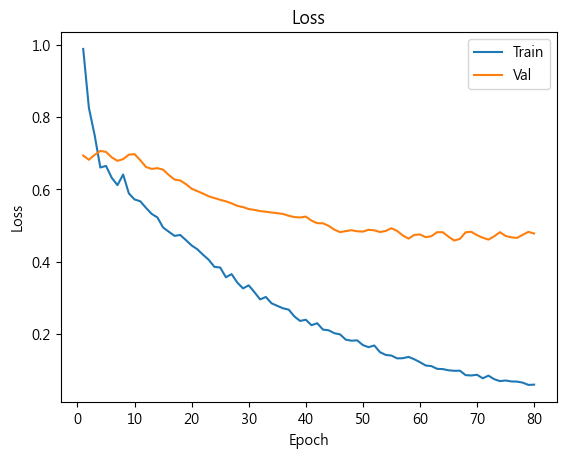

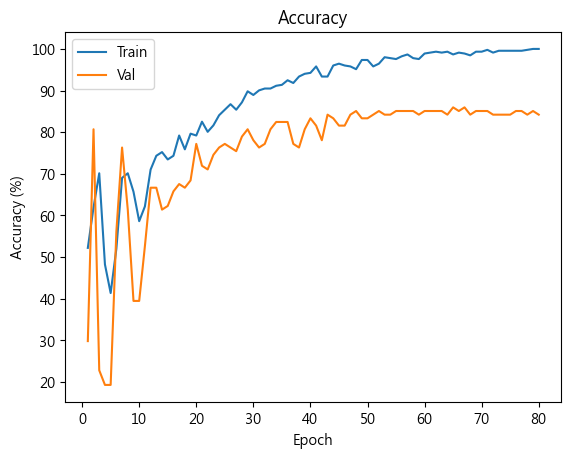

分類報告：
               precision    recall  f1-score   support

         bad       0.59      0.59      0.59        22
        good       0.90      0.90      0.90        92

    accuracy                           0.84       114
   macro avg       0.75      0.75      0.75       114
weighted avg       0.84      0.84      0.84       114



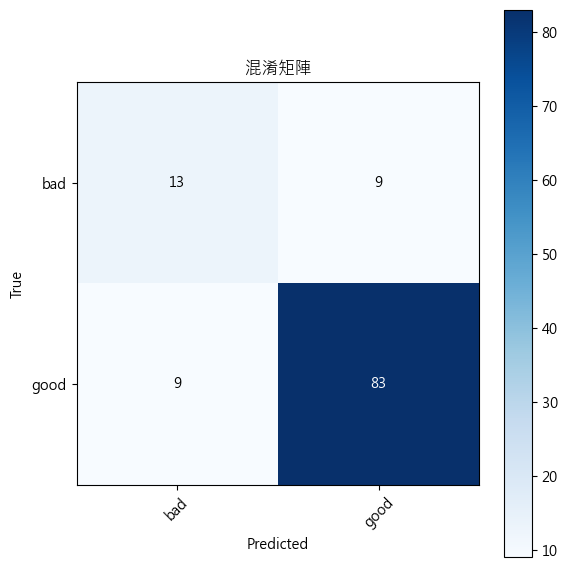

In [2]:
# ========= 0. 全域參數 =========
bean_type   = "honduras_natural"         # ← 想換其他豆種直接改
use_noback  = True                      # True → 使用 *_Noback 資料夾
subfolder   = "corp_augmented_dataNoback" if use_noback else "corp_augmented_data"
dataset_path = f"coffee_beans_data/{bean_type}/{subfolder}"

batch_size  = 256
img_size    = 128
num_epochs  = 80
lr          = 5e-5
model_name  = "custom"                  # 'resnet18' | 'convnext_tiny' | 'custom' | 'ultrafast'

# ========= 1. import =========
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import (
    resnet18, ResNet18_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights
)
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Microsoft JhengHei"
plt.rcParams["axes.unicode_minus"] = False
from sklearn.metrics import classification_report, confusion_matrix
import torchvision.transforms.functional as TF

# ========= 2. 工具函式 =========
def pad_to_square(img, fill=0):
    """保持比例，以最短邊為基準 pad 成正方形。"""
    w, h = img.size
    if w == h: 
        return img
    diff = abs(h - w)
    pad1, pad2 = diff // 2, diff - diff // 2
    padding = (0, pad1, 0, pad2) if h < w else (pad1, 0, pad2, 0)
    return TF.pad(img, padding, fill=fill)

# ========= 3. EarlyStopping =========
class EarlyStopping:
    def __init__(self, patience=16, verbose=True, delta=0):
        self.patience  = patience
        self.verbose   = verbose
        self.delta     = delta
        self.counter   = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            if self.verbose and self.best_loss is not None:
                print(f"✅ 驗證 loss 降低: {self.best_loss:.4f} → {val_loss:.4f}，重置早停計數器")
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"⚠️ 早停計數器: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# ========= 4. 模型工廠 =========
def get_model(name: str, num_classes: int, img_size: int):
    if name == "resnet18":
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "convnext_tiny":
        model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)

    elif name == "custom":
        class CustomCNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                    nn.MaxPool2d(2)
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(128 * (img_size // 8) * (img_size // 8), 256),
                    nn.ReLU(), nn.Dropout(0.5),
                    nn.Linear(256, num_classes)
                )
            def forward(self, x):
                return self.classifier(self.features(x))
        model = CustomCNN()

    elif name == "ultrafast":
        class UltraFastCNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 8, 5, 2, 1), nn.ReLU(),        # 128→64
                    nn.Conv2d(8, 16, 5, 2, 1), nn.ReLU(),       # 64→32
                    nn.Conv2d(16, 32, 3, 2, 1), nn.ReLU(),      # 32→16
                    nn.AdaptiveAvgPool2d((1,1))
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(32, num_classes)
                )
            def forward(self, x):
                return self.classifier(self.features(x))
        model = UltraFastCNN()

    else:
        raise ValueError(f"未知模型: {name}")
    return model

# ========= 5. 訓練 / 驗證 =========
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * lbls.size(0)
        correct += (out.argmax(1) == lbls).sum().item()
        total += lbls.size(0)
    return running_loss / total, 100 * correct / total

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs)
        loss = criterion(out, lbls)

        running_loss += loss.item() * lbls.size(0)
        correct += (out.argmax(1) == lbls).sum().item()
        total += lbls.size(0)
    return running_loss / total, 100 * correct / total

# ========= 6. 可視化 =========
def plot_metrics(hist):
    ep = range(1, len(hist["train_loss"]) + 1)
    plt.figure(); plt.plot(ep, hist["train_loss"], label="Train"); plt.plot(ep, hist["val_loss"], label="Val")
    plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

    plt.figure(); plt.plot(ep, hist["train_acc"], label="Train"); plt.plot(ep, hist["val_acc"], label="Val")
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.show()

# ========= 7. 評估 =========
@torch.no_grad()
def evaluate_model(model, loader, device, classes):
    model.eval()
    all_preds, all_lbls = [], []
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        all_preds.extend(model(imgs).argmax(1).cpu().tolist())
        all_lbls.extend(lbls.cpu().tolist())

    print("分類報告：\n", classification_report(all_lbls, all_preds, target_names=classes))

    cm = confusion_matrix(all_lbls, all_preds)
    plt.figure(figsize=(6,6)); plt.imshow(cm, cmap=plt.cm.Blues); plt.title("混淆矩陣"); plt.colorbar()
    ticks = range(len(classes))
    plt.xticks(ticks, classes, rotation=45); plt.yticks(ticks, classes)
    thresh = cm.max() / 2
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i, j], ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()

# ========= 8. main =========
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 資料增強 & 載入
    transform = transforms.Compose([
        transforms.Lambda(lambda img: pad_to_square(img, fill=0)),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    dataset = datasets.ImageFolder(dataset_path, transform=transform)
    num_classes = len(dataset.classes)

    train_size = int(0.8 * len(dataset))
    test_size  = len(dataset) - train_size
    train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    print(f"類別對應：{dataset.class_to_idx}")

    # 建模
    # 計算每個類別的樣本數
    class_counts = [0] * num_classes
    for _, label in dataset.samples:
        class_counts[label] += 1
    class_weights = [0 if c == 0 else 1.0 / c for c in class_counts]
    # 正規化權重
    total = sum(class_weights)
    class_weights = [w / total * num_classes for w in class_weights]
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    model = get_model(model_name, num_classes, img_size).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    stopper = EarlyStopping(patience=16, verbose=True)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, num_epochs+1):
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        v_loss, v_acc = validate(model, test_loader, criterion, device)

        print(f"[{epoch:03}/{num_epochs}] "
              f"Train: loss {t_loss:.4f} acc {t_acc:.2f}%  |  "
              f"Val: loss {v_loss:.4f} acc {v_acc:.2f}%")

        history["train_loss"].append(t_loss); history["train_acc"].append(t_acc)
        history["val_loss"].append(v_loss);   history["val_acc"].append(v_acc)

        stopper(v_loss, model)
        if stopper.early_stop:
            print("🛑 觸發早停，停止訓練")
            break

    # 儲存最佳模型
    suffix = "_Noback" if use_noback else ""
    best_path = f"{bean_type}_{model_name}{suffix}_best_model.pth"
    torch.save(stopper.best_model_state, best_path)
    print(f"✅ 已儲存最佳模型：{best_path}")

    # 視覺化 & 評估
    plot_metrics(history)
    evaluate_model(model, test_loader, device, dataset.classes)

# ========= 9. 執行 =========
if __name__ == "__main__":
    main()